In [ ]:
# %% Imports & global setup ---------------------------------------------------
import json, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.decoding import (
    Scaler, Vectorizer, LinearModel, SlidingEstimator, cross_val_multiscore, get_coef
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

from pyddeeg import EEG_CHANNELS, RQA_METRICS

# ---------- Dataset parameters ---------------------------------------------
DATASET_ROOT = Path("/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset")
WINDOW       = "window_200"   # 200‑ms window length
DIRECTION    = "up"

meta = np.load(DATASET_ROOT / WINDOW / "metadata.npz")
centres_ms = meta["centers"].astype(int)   # e.g. [100, 200, …] length 679
STRIDE_MS  = int(meta["stride"])           # 100 ms
WINDOW_MS  = int(WINDOW.split("_")[-1])    # 200 ms
TOTAL_MS   = centres_ms[-1] + WINDOW_MS//2  # expected 68 000 ms
SFREQ      = 1000 / STRIDE_MS

routes = json.loads((DATASET_ROOT / "dataset_index.json").read_text())[WINDOW][DIRECTION]

# CV splitter ---------------------------------------------------------------
try:
    CV = StratifiedGroupKFold(n_splits=5)
    CV_NAME = "StratifiedGroupKFold"
except ImportError:
    CV = GroupKFold(n_splits=5)
    CV_NAME = "GroupKFold"
    
from pyddeeg.classification.dataloaders import EEGDataset
from pyddeeg.classification.engine import trainer

dataset = EEGDataset.load(dataset_root=DATASET_ROOT, window=WINDOW, direction=DIRECTION, random_state=42)
elec="T7"
results = trainer.compute_auc_per_electrode(elec=elec, 
                                  dataset=dataset, 
                                  model=LinearModel(LogisticRegression(max_iter=1000)))
np.savez(DATASET_ROOT / WINDOW / f"results_{DIRECTION}_{elec}.npz",
         results=results, 
         dataset=dataset)

In [1]:
import numpy as np
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from pyddeeg.classification.dataloaders import EEGDataset
from pyddeeg.classification.engine.trainer import classification_per_electrode, permutation_test_decision_scores
from mne.decoding import LinearModel
# ------------------ user parameters (EDIT THESE) ------------------ #
DATASET_ROOT = Path("/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset")
WINDOW       = "window_200"   
DIRECTION    = "up"                      
ELECTRODE    = "T7"
SEED = 42
# ------------------------------------------------------------------ #

dataset = EEGDataset.load(DATASET_ROOT, WINDOW, DIRECTION, random_state=SEED)
print("✅ Loaded real dataset")

# ------------------ model definition ------------------ #
model = LinearModel(LogisticRegression(max_iter=1000,
                           class_weight='balanced',
                           solver='liblinear',
                           random_state=SEED))

# ------------------ run classification ------------------ #
results = classification_per_electrode(ELECTRODE, dataset, model)

# ------------------ permutation test ------------------ #
stats = permutation_test_decision_scores(results['decision_scores'],
                                         results['labels'],
                                         n_permutations=1000,
                                         tail=1,
                                         threshold=dict(start=0.0, step=0.2),
                                         seed=SEED)


print("\n===== SUMMARY =====")
print(f"Decision‑score matrix shape : {results['decision_scores'].shape}")
print(f"Fold‑AUC tensor shape       : {results['fold_auc'].shape}")
print(f"Number of clusters (p<0.05) : {(stats['p_values'] < 0.05).sum()}")


✅ Loaded real dataset
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


100%|██████████| Fitting SlidingEstimator : 679/679 [00:07<00:00,   93.84it/s]
100%|██████████| Fitting SlidingEstimator : 679/679 [00:07<00:00,   92.15it/s]
100%|██████████| Fitting SlidingEstimator : 679/679 [00:07<00:00,   91.07it/s]
100%|██████████| Fitting SlidingEstimator : 679/679 [00:07<00:00,   94.09it/s]t/s]
100%|██████████| Fitting SlidingEstimator : 679/679 [00:07<00:00,   92.92it/s]it/s]
100%|██████████| Transforming SlidingEstimator : 679/679 [00:00<00:00, 1188.07it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]
  1%|          | Fitting SlidingEstimator : 4/679 [00:00<00:11,   59.14it/s]
  2%|▏         | Fitting SlidingEstimator : 11/679 [00:00<00:06,  100.64it/s]
  3%|▎         | Fitting SlidingEstimator : 18/679 [00:00<00:06,  107.98it/s]

  0%|          | Fitting SlidingEstimator : 0/679 [00:00<?,       ?it/s]
  4%|▍         | Fitting SlidingEstimator : 27/679 [00:

stat_fun(H1): min=0.046061485466801826 max=0.04606148546724316
Running initial clustering …
Using 1 thresholds from 0.00 to 0.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 2 clusters


100%|██████████| Permuting : 999/999 [00:00<00:00, 1336.37it/s]



===== SUMMARY =====
Decision‑score matrix shape : (49, 2)
Fold‑AUC tensor shape       : (5, 2, 679)
Number of clusters (p<0.05) : 0


In [ ]:
np.save(file = DATASET_ROOT / WINDOW / f"results_{DIRECTION}_{ELECTRODE}.npz", arr={"results": results, "stats": stats})

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (2760617375.py, line 1)

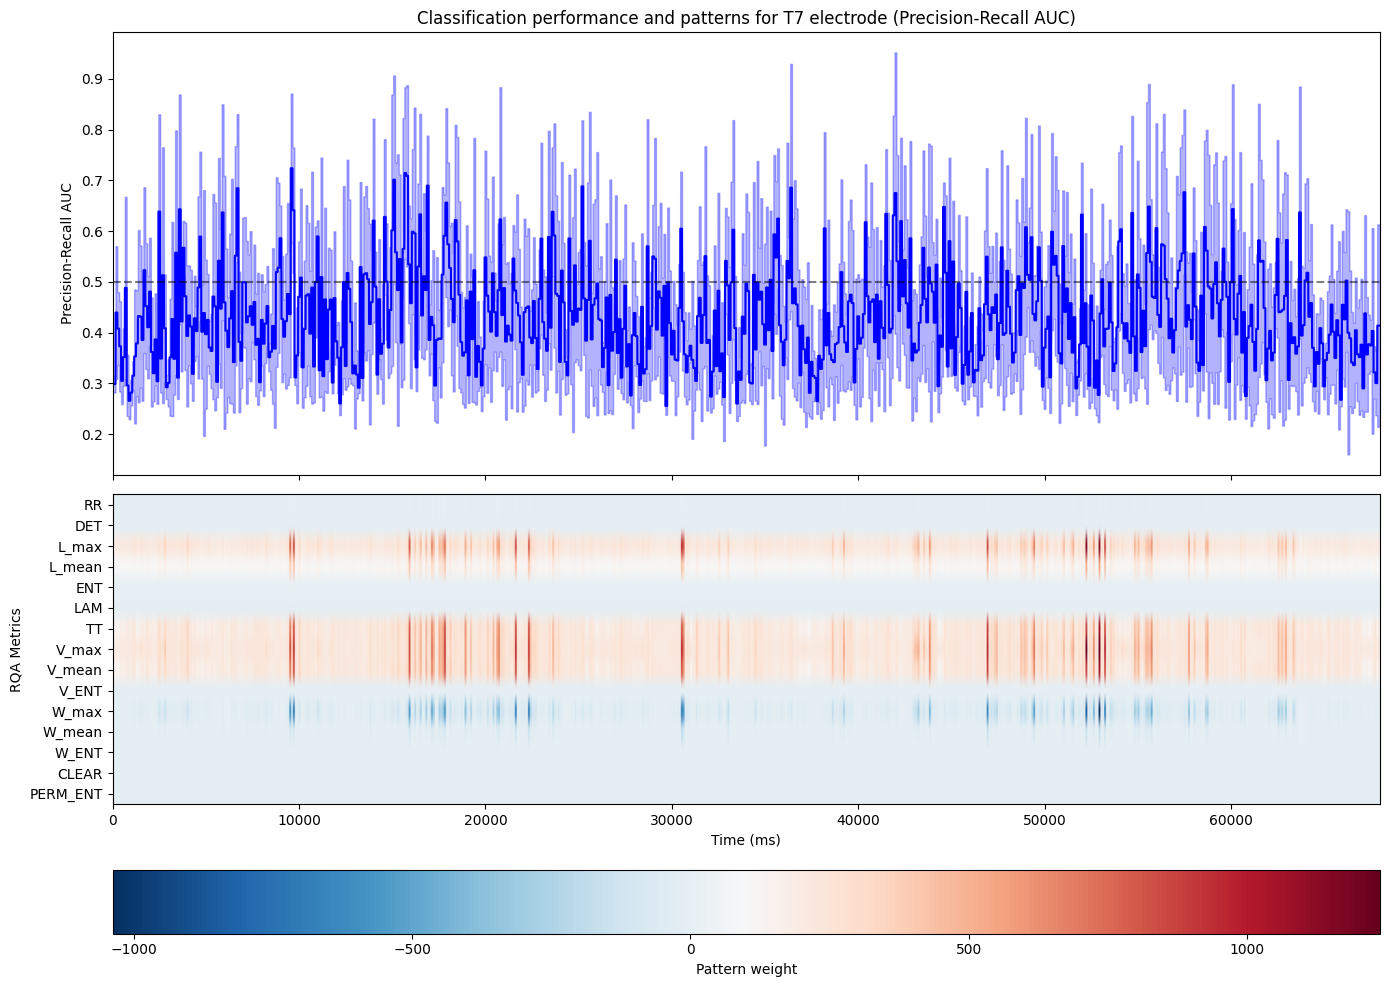

In [13]:
from pyddeeg.classification.utils.basic_visualizations import plot_classification_results

# Basic usage with default styling
fig, axes = plot_classification_results(results, "T7", dataset, metric="pr")

plt.show()